In [1]:
import yaml
import click
import torch
import tqdm.auto
import numpy as np
from torchvision.models import vit_b_16

from matplotlib import pyplot as plt


import sys
import os
import re
import math
#project_root = "C:/Users/elmop/deep_feature_reweighting/deep_feature_reweighting/external/pruning_by_explaining"
project_root = "/home/primmere/ide/external/pruning_by_explaining"
sys.path.insert(0, project_root)                 
sys.path.insert(0, os.path.dirname(project_root))

from pruning_by_explaining.models import ModelLoader
from pruning_by_explaining.metrics import compute_accuracy
from pruning_by_explaining.my_metrics import compute_worst_accuracy
from pruning_by_explaining.my_datasets import WaterBirds, get_sample_indices_for_group, WaterBirdSubset, ISIC, ISICSubset
from pruning_by_explaining.utils import (
    initialize_random_seed,
    initialize_wandb_logger,
)


from pruning_by_explaining.pxp import (
    ModelLayerUtils,
    get_cnn_composite,
    get_vit_composite,
)

from pruning_by_explaining.pxp import GlobalPruningOperations
from pruning_by_explaining.pxp import ComponentAttibution

from pruning_by_explaining.my_experiments.utils import visualise, plot_layer_head_heatmap, plot_layer_head_pruned, plot_r_accuracy_lines



In [2]:
seed = 6
# seed 3, 30 samples, v1 - v2 - v3 with _div(rel*4) for both boosts group 1
initialize_random_seed(seed)
num_workers = 8
device_string = "cuda"
device = torch.device(device_string)
waterbirds = WaterBirds('/scratch_shared/primmere/waterbird', seed = seed, num_workers = num_workers)
least_rel_first = True
abs_flag = True
least_rel_first2 = False
abs_flag2 = False
Zplus_flag = True

scale_bool = True

prune_r = [0.001,0.01,0.05,0.1, 0.2, 0.3, 0.4]



layer_type = 'Softmax'
new_checkpoint_path = "checkpoints/wb_30_0123_minus_2_div_2_r0.3.pth"
save = False

train_set = waterbirds.get_train_set()
val_set = waterbirds.get_valid_set()
test_set = waterbirds.get_test_set()
target_grp = [1]
pruning_indices = get_sample_indices_for_group(val_set, 100, device_string,[0,1,2,3])
pruning_indices2 = get_sample_indices_for_group(val_set, 100, device_string, target_grp)
pruning_indices = pruning_indices + pruning_indices2
print(len(pruning_indices))
print(len(pruning_indices2))

pruning_indices3 = get_sample_indices_for_group(val_set, 35, device_string, [2])
validation_indices = get_sample_indices_for_group(test_set, 'all', device_string)


custom_pruning_set = WaterBirdSubset(val_set, pruning_indices)
custom_pruning_set2 = WaterBirdSubset(val_set, pruning_indices2)
custom_pruning_set3 = WaterBirdSubset(val_set, pruning_indices3)

custom_val_set = WaterBirdSubset(test_set, validation_indices)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=num_workers)
prune_dataloader = torch.utils.data.DataLoader(custom_pruning_set, batch_size=1, shuffle=True, num_workers=num_workers)
prune_dataloader2 = torch.utils.data.DataLoader(custom_pruning_set2, batch_size=8, shuffle=True, num_workers=num_workers)
prune_dataloader3 = torch.utils.data.DataLoader(custom_pruning_set3, batch_size=8, shuffle=True, num_workers=num_workers)
val_dataloader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=num_workers)

[0 1 2 3]
Number of unique labels: 2, Number of unique places: 2, Total groups: 4
group 0: 3518
group 1: 185
group 2: 55
group 3: 1037
[0 1 2 3]
Number of unique labels: 2, Number of unique places: 2, Total groups: 4
group 0: 456
group 1: 456
group 2: 143
group 3: 144
[0 1 2 3]
Number of unique labels: 2, Number of unique places: 2, Total groups: 4
group 0: 2255
group 1: 2255
group 2: 642
group 3: 642
target groups: [0, 1, 2, 3]
target groups: [1]
500
100
target groups: [2]


In [3]:
suggested_composite = {
        "low_level_hidden_layer_rule": "Epsilon",
        "mid_level_hidden_layer_rule":"Epsilon",
        "high_level_hidden_layer_rule": "Epsilon",
        "fully_connected_layers_rule": "Epsilon",
        "softmax_rule": "Epsilon",
    }
composite = get_vit_composite("vit_b_16", suggested_composite)
layer_types = {
        "Softmax": torch.nn.Softmax,
        "Linear": torch.nn.Linear,
        "Conv2d": torch.nn.Conv2d,
    }

In [4]:
model = ModelLoader.get_basic_model("vit_b_16", "/home/primmere/ide/dfr/logs/vit_waterbirds.pth", device, num_classes=2)
model2 = ModelLoader.get_basic_model("vit_b_16", "/home/primmere/ide/dfr/logs/vit_waterbirds.pth", device, num_classes=2)
model3 = ModelLoader.get_basic_model("vit_b_16", "/home/primmere/ide/dfr/logs/vit_waterbirds.pth", device, num_classes=2)



Arch:vit_b_16


/home/primmere/ide/external/pruning_by_explaining/models/utils.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_checkpoint = torch.load(checkpoint_path, map_locat

Arch:vit_b_16
Arch:vit_b_16


In [5]:
"""
acc, acc_groups = compute_worst_accuracy(
        model,
        train_dataloader,
        device,
    )
print(acc)
for i in range(4):
    print(f'{i}: {acc_groups[i]}')

"""


"""
0: 0.9937915742793791
1: 0.7835920177383592
2: 0.7461059190031153
3: 0.956386292834891
"""


'\n0: 0.9937915742793791\n1: 0.7835920177383592\n2: 0.7461059190031153\n3: 0.956386292834891\n'

In [6]:
"""
acc = compute_accuracy(
        model,
        val_dataloader,
        device,
    )
print(acc)
"""

'\nacc = compute_accuracy(\n        model,\n        val_dataloader,\n        device,\n    )\nprint(acc)\n'

In [7]:
component_attributor = ComponentAttibution(
        "Relevance",
        "ViT",
        layer_types[layer_type],
        least_rel_first
    )

components_relevances = component_attributor.attribute(
        model,
        prune_dataloader,
        composite,
        abs_flag=abs_flag,
        Zplus_flag=False,
        device=device,
    )

layer_names = component_attributor.layer_names
pruner = GlobalPruningOperations(
        layer_types[layer_type],
        layer_names,
    )

global_pruning_mask = pruner.generate_global_pruning_mask(
                model,
                components_relevances,
                0.1,
                subsequent_layer_pruning=layer_type,
                least_relevant_first=least_rel_first,
                device=device,
            )
print("done!")



/home/primmere/.conda/envs/dfr2/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


done!


In [8]:
#hook_handles = pruner.fit_pruning_mask(model, global_pruning_mask,)
#print(hook_handles)

In [9]:
component_attributor2 = ComponentAttibution(
        "Relevance",
        "ViT",
        layer_types[layer_type],
        least_rel_first2
    )

components_relevances2 = component_attributor2.attribute(
        model2,
        prune_dataloader2,
        composite,
        abs_flag=abs_flag2,
        Zplus_flag=Zplus_flag,
        device=device,
    )
layer_names2 = component_attributor.layer_names
pruner2 = GlobalPruningOperations(
        layer_types[layer_type],
        layer_names2,
    )

global_pruning_mask2 = pruner2.generate_global_pruning_mask(
                model2,
                components_relevances2,
                0.1,
                subsequent_layer_pruning=layer_type,
                least_relevant_first=least_rel_first,
                device=device,
            )
print("done!")

done!


In [10]:
component_attributor3 = ComponentAttibution(
        "Relevance",
        "ViT",
        layer_types[layer_type],
        least_rel_first2
    )

components_relevances3 = component_attributor3.attribute(
        model3,
        prune_dataloader3,
        composite,
        abs_flag=abs_flag2,
        Zplus_flag=Zplus_flag,
        device=device,
    )
layer_names3 = component_attributor.layer_names
pruner3 = GlobalPruningOperations(
        layer_types[layer_type],
        layer_names3,
    )

global_pruning_mask3 = pruner2.generate_global_pruning_mask(
                model3,
                components_relevances3,
                0.1,
                subsequent_layer_pruning=layer_type,
                least_relevant_first=least_rel_first,
                device=device,
            )
print("done!")

done!


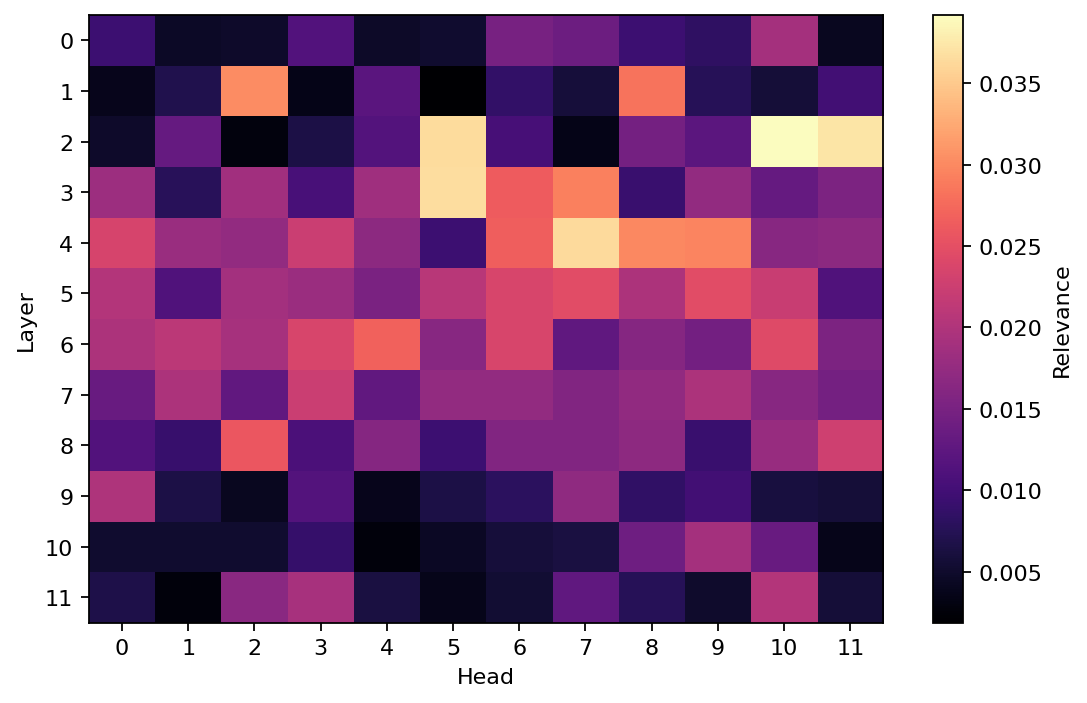

(<Figure size 1120x720 with 2 Axes>, <Axes: xlabel='Head', ylabel='Layer'>)

In [11]:
plot_layer_head_heatmap(components_relevances2, normalise = len(pruning_indices), save_path = f'heatmaps/wb_{layer_type}_{target_grp[0]}_100')

In [12]:
#plot_layer_head_heatmap(components_relevances2, normalise = len(pruning_indices2))

In [13]:
#plot_layer_head_heatmap(components_relevances3, normalise = len(pruning_indices3))

In [14]:
#hook_handles = pruner.fit_pruning_mask(model2, global_pruning_mask2,)
#print(hook_handles)

In [15]:
"""acc_worst, acc_groups = compute_worst_accuracy(
        model,
        val_dataloader,
        device,
    )
for i in range(4):
    print(f'{i}: {acc_groups[i]}')
    """


"acc_worst, acc_groups = compute_worst_accuracy(\n        model,\n        val_dataloader,\n        device,\n    )\nfor i in range(4):\n    print(f'{i}: {acc_groups[i]}')\n    "

In [16]:
"""
0: 0.9868421052631579
1: 0.7982456140350878
2: 0.7272727272727273
3: 0.9791666666666666
"""

'\n0: 0.9868421052631579\n1: 0.7982456140350878\n2: 0.7272727272727273\n3: 0.9791666666666666\n'

In [17]:
"""
acc_worst, acc_groups = compute_worst_accuracy(
        model,
        val_dataloader,
        device,
    )
for i in range(4):
    print(f'{i}: {acc_groups[i]}')
"""


"\nacc_worst, acc_groups = compute_worst_accuracy(\n        model,\n        val_dataloader,\n        device,\n    )\nfor i in range(4):\n    print(f'{i}: {acc_groups[i]}')\n"

In [18]:
"""
acc_worst, acc_groups = compute_worst_accuracy(
        model2,
        val_dataloader,
        device,
    )
for i in range(4):
    print(f'{i}: {acc_groups[i]}')

"""

"\nacc_worst, acc_groups = compute_worst_accuracy(\n        model2,\n        val_dataloader,\n        device,\n    )\nfor i in range(4):\n    print(f'{i}: {acc_groups[i]}')\n\n"

In [19]:
scale = len(pruning_indices)
if scale_bool:
    for t in components_relevances.values():
        t.div_(scale)

In [20]:
"""
for k,v in components_relevances.items():
    if "mlp.3" in k:
        v.div_(4)

for k,v in components_relevances2.items():
    if "mlp.3" in k:
        v.div_(4)

for k,v in components_relevances3.items():
    if "mlp.3" in k:
        v.div_(4)

"""

'\nfor k,v in components_relevances.items():\n    if "mlp.3" in k:\n        v.div_(4)\n\nfor k,v in components_relevances2.items():\n    if "mlp.3" in k:\n        v.div_(4)\n\nfor k,v in components_relevances3.items():\n    if "mlp.3" in k:\n        v.div_(4)\n\n'

In [21]:
scale2 = len(pruning_indices2)
scale3 = len(pruning_indices3)
if scale_bool :
    for t in components_relevances2.values():
        t.div_(scale2*2)
    for t in components_relevances3.values():
        t.div_(scale3*2)

In [22]:
print(scale, scale2)

500 100


In [23]:
for k in components_relevances2.keys():
    #print(torch.mean(v))
    a = torch.mean(components_relevances[k]).item()
    b = torch.mean(components_relevances2[k]).item()
    c = torch.mean(components_relevances3[k]).item()
    print(f'{a:.3f}, {b:.3f}, {c:.3f}')

0.043, 0.023, 0.010
0.047, 0.026, 0.009
0.073, 0.040, 0.014
0.093, 0.046, 0.018
0.103, 0.055, 0.018
0.101, 0.048, 0.020
0.105, 0.049, 0.019
0.087, 0.042, 0.015
0.089, 0.038, 0.017
0.050, 0.023, 0.010
0.040, 0.020, 0.009
0.051, 0.023, 0.012


In [24]:
for name, R in components_relevances.items():
    print(name, torch.sum(R).item())

encoder.layers.encoder_layer_0.self_attention.softmax 0.5175738334655762
encoder.layers.encoder_layer_1.self_attention.softmax 0.5641222596168518
encoder.layers.encoder_layer_2.self_attention.softmax 0.8766366243362427
encoder.layers.encoder_layer_3.self_attention.softmax 1.112927794456482
encoder.layers.encoder_layer_4.self_attention.softmax 1.2398509979248047
encoder.layers.encoder_layer_5.self_attention.softmax 1.211920976638794
encoder.layers.encoder_layer_6.self_attention.softmax 1.2587082386016846
encoder.layers.encoder_layer_7.self_attention.softmax 1.043785572052002
encoder.layers.encoder_layer_8.self_attention.softmax 1.063421607017517
encoder.layers.encoder_layer_9.self_attention.softmax 0.6038761138916016
encoder.layers.encoder_layer_10.self_attention.softmax 0.47745949029922485
encoder.layers.encoder_layer_11.self_attention.softmax 0.6082099080085754


In [25]:
"""
combined_relevances = {}
for (k, v), (k2, v2) in zip(components_relevances.items(), components_relevances2.items()):
    combined_relevances[k] = v-v2

"""
    

'\ncombined_relevances = {}\nfor (k, v), (k2, v2) in zip(components_relevances.items(), components_relevances2.items()):\n    combined_relevances[k] = v-v2\n\n'

In [26]:
combined_relevances = {}
check = True
for (k1, v1), (k2, v2), (k3, v3) in zip(
        components_relevances.items(), components_relevances2.items(), components_relevances3.items()
):
    check = check & (k1==k2==k3)
    combined_relevances[k1] = v1 - v2
print(check)

True


In [27]:
#plot_layer_head_heatmap(components_relevances, normalise = len(pruning_indices3))

In [28]:
accs = np.zeros((len(prune_r),6))
i = 0

for r in prune_r:
    global_pruning_mask_combined = pruner.generate_global_pruning_mask(
                    model,
                    combined_relevances,
                    r,
                    subsequent_layer_pruning=layer_type,
                    least_relevant_first=True,
                    device=device,
                )
    hook_handles = pruner.fit_pruning_mask(model, global_pruning_mask_combined,)
    
    acc, acc_groups = compute_worst_accuracy(
            model,
            val_dataloader,
            device,
        )
    accs[i]=np.array([r,acc,acc_groups[0],acc_groups[1],acc_groups[2],acc_groups[3]])
    i += 1
    print(f'{r} & {acc:.3f} & {acc_groups[0]:.3f} & {acc_groups[1]:.3f} & {acc_groups[2]:.3f} & {acc_groups[3]:.3f} \\\\')
    

evaluating group acc:   0%|          | 0/46 [00:00<?, ?it/s]

0.001 & 0.880 & 0.994 & 0.784 & 0.746 & 0.956 \\


evaluating group acc:   0%|          | 0/46 [00:00<?, ?it/s]

0.01 & 0.897 & 0.994 & 0.825 & 0.760 & 0.950 \\


evaluating group acc:   0%|          | 0/46 [00:00<?, ?it/s]

0.05 & 0.903 & 0.995 & 0.845 & 0.741 & 0.947 \\


evaluating group acc:   0%|          | 0/46 [00:00<?, ?it/s]

0.1 & 0.902 & 0.995 & 0.842 & 0.740 & 0.949 \\


evaluating group acc:   0%|          | 0/46 [00:00<?, ?it/s]

0.2 & 0.898 & 0.994 & 0.834 & 0.735 & 0.947 \\


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1515c6c33010>
Traceback (most recent call last):
  File "/home/primmere/.conda/envs/dfr2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/home/primmere/.conda/envs/dfr2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/home/primmere/.conda/envs/dfr2/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1515c6c33010>
Traceback (most recent call last):
  File "/home/primmere/.conda/envs/dfr2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/home/primmere/.conda/envs/dfr2/lib/python3.10/site-p

evaluating group acc:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x1515c6c33010>
  File "/home/primmere/.conda/envs/dfr2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/home/primmere/.conda/envs/dfr2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1515c6c33010>if w.is_alive():

Traceback (most recent call last):
  File "/home/primmere/.conda/envs/dfr2/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/home/primmere/.conda/envs/dfr2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

  File "/home/primmere/.conda/envs/dfr2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 

0.3 & 0.891 & 0.993 & 0.824 & 0.713 & 0.949 \\


evaluating group acc:   0%|          | 0/46 [00:00<?, ?it/s]

0.4 & 0.895 & 0.995 & 0.848 & 0.670 & 0.939 \\


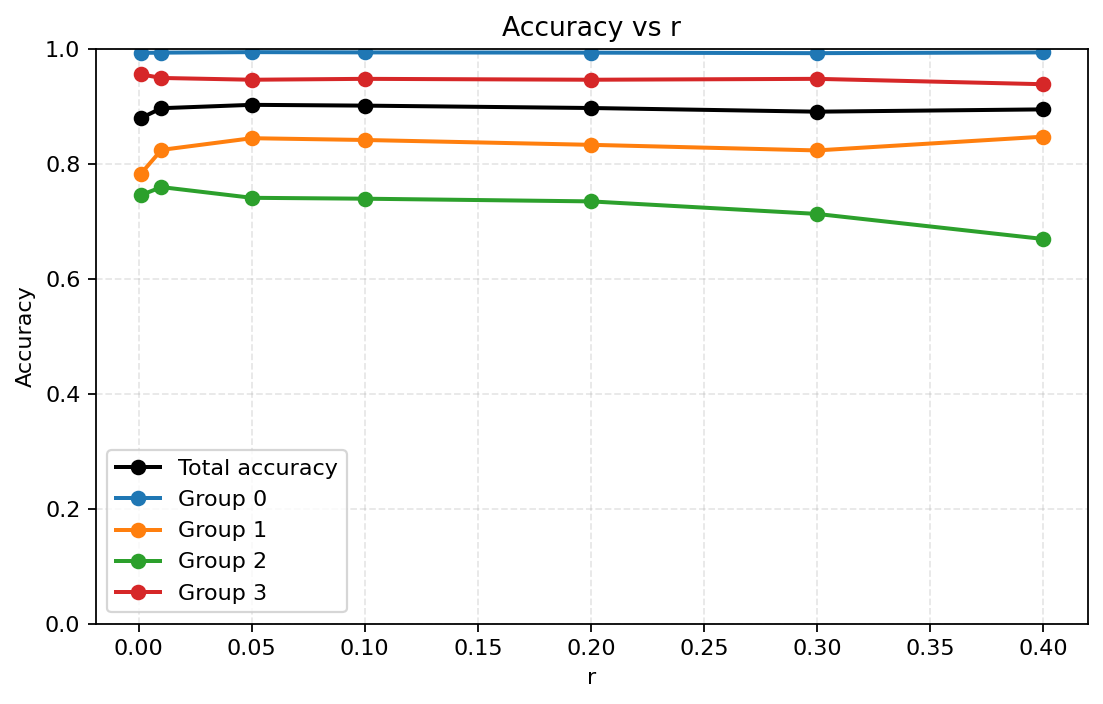

(<Figure size 1120x720 with 1 Axes>,
 <Axes: title={'center': 'Accuracy vs r'}, xlabel='r', ylabel='Accuracy'>)

In [29]:
plot_r_accuracy_lines(accs)

In [30]:

count=0
for n, t in global_pruning_mask_combined.items():
    param_total = t['Linear']['weight'].numel()
    param_nonzero = t['Linear']['weight'].nonzero().size(0)
    param_shape = t['Linear']['weight'].shape
    
    pruned = (param_total-param_nonzero)/param_shape[1]
    total = param_total/param_shape[1]
    #print(pruned, "/", total, "pruned,", pruned/total)
    print(f'{100*pruned/total:.1f}% - {pruned} / {total} pruned')


IndexError: too many indices for tensor of dimension 1

In [ ]:

acc, acc_groups = compute_worst_accuracy(
        model,
        val_dataloader,
        device,
    )
print(acc)
for i in range(4):
    print(f'{i}: {acc_groups[i]}')



In [ ]:
#global_pruning_mask

In [ ]:
#global_pruning_mask2

In [ ]:
for v, v2 in zip(components_relevances.values(), components_relevances3.values()):
    print(v[0:8])
    print(v3[0:8])
    print(v[0:8]-v3[0:8])
    print("--")

In [ ]:
#print(f'{prune_r},{acc:.3f},{acc_groups[0]:.3f},{acc_groups[1]:.3f},{acc_groups[2]:.3f},{acc_groups[3]:.3f}')

In [ ]:
#print(f'{r} & {acc:.3f} & {acc_groups[0]:.3f} & {acc_groups[1]:.3f} & {acc_groups[2]:.3f} & {acc_groups[3]:.3f} \\\\')

In [ ]:
for v in component

In [ ]:
#visualise(global_pruning_mask_combined, r, layer_type)

In [ ]:
print(hook_handles)

In [ ]:
if save and not (layer_type == 'Softmax'):
    torch.save(model.state_dict(), new_checkpoint_path)

In [ ]:
def parse_head_mask(head_mask):
    """
    head_mask: OrderedDict, output of pxp
    returns   : dict {int(layer_index) -> list[int(head_idx)]}
    """
    pat = re.compile(r'encoder_layer_(\d+)')
    pruned = {}
    for name, heads in head_mask.items():
        m = pat.search(name)
        if m is None or len(heads) == 0:
            continue
        layer_idx = int(m.group(1))
        pruned[layer_idx] = heads.tolist()
    return pruned

@torch.no_grad()
def zero_vit_heads(model, prunable_head_dict):
    """
    Apply pxp pruning
    Zero Q/K/V and out-proj slices of given heads

    prunable_head_dict: dict {layer_idx -> list[int(head_id)]}
    """
    for idx, block in enumerate(model.encoder.layers):
        if idx not in prunable_head_dict:
            continue

        attn = getattr(block, "self_attention", None)

        if attn is None:
            raise RuntimeError(f"Could not find attention module in layer {idx}")

        hdim = attn.head_dim  # 64
        nheads = attn.num_heads  # 12
        edim = attn.embed_dim  # 768

        in_w = attn.in_proj_weight  # (3*edim, edim)
        in_b = getattr(attn, "in_proj_bias", None)
        out_w = attn.out_proj.weight  # (edim, edim)
        out_b = attn.out_proj.bias

        for h in prunable_head_dict[idx]:
            rows = slice(h * hdim, (h + 1) * hdim)

            # Q, K, V are stacked: [0:edim]   [edim:2*edim]   [2*edim:3*edim]
            for blk in range(3):
                r = slice(rows.start + blk * edim, rows.stop + blk * edim)
                in_w[r].zero_()
                if in_b is not None:
                    in_b[r].zero_()

            out_w[:, rows].zero_()

        if out_b is not None and len(prunable_head_dict[idx]) == nheads:
            out_b.zero_()  # whole attention output is zero

        print(f"layer {idx:2d}: pruned heads {prunable_head_dict[idx]}")

    print("all requested heads have been zero-ed")

In [ ]:
if layer_type == 'Softmax':
    checkpoint = torch.load("/home/primmere/ide/dfr/logs/vit_waterbirds.pth", map_location=torch.device('cuda'), weights_only=True)
    model2 = vit_b_16(num_classes = 2)
    model2.load_state_dict(checkpoint)
    mask_dict = parse_head_mask(global_pruning_mask_combined)
    zero_vit_heads(model2, mask_dict)

In [ ]:
acc, acc_groups = compute_worst_accuracy(
        model2,
        val_dataloader,
        device,
    )
print(acc)
for i in range(4):
    print(f'{i}: {acc_groups[i]}')

In [ ]:
if save and (layer_type == 'Softmax'):
    torch.save(model2.state_dict(), new_checkpoint_path)
    print('saved')

In [ ]:
global_pruning_mask_combined

In [ ]:
len(pruning_indices2)